# Nice Ride Bike Share Exploratory Data Analysis

TODO: description / intro...

Nice Ride MN shares their [historical system data](https://www.niceridemn.org/data/)

## Outline
- [Data Loading and Cleaning](#loading-and-cleaning)
- [Station Locations](#station-locations)
- [Number of Bike Docks per Station](#number-of-docks)
- [Station Demand](#station-demand)
    - [Difference in demand](#difference-in-demand)
    - [Difference in demand over time](#demand-over-time)
    - [Cumulative difference in demand](#cumulative-difference)
    - [Optimal initial number of bikes](#optimal-initial-number)
    - [Demand Range](#demand-range)
- [Flow](#flow)
- [Ride Season](#ride-season)
- [Ride durations](#ride-durations)
- [Weather](#weather)
- [Traffic dependence on season](#dependence-on-season)
- [Memberships](#memberships)

In [ ]:
# Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Matplotlib settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set()

# Bokeh settings
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, Circle, HoverTool, ColorBar, LinearColorMapper, LogColorMapper, CustomJS, Slider
from bokeh.palettes import Viridis256, brewer
from bokeh.tile_providers import CARTODBPOSITRON_RETINA
from bokeh.models.widgets import Panel, Tabs
from bokeh.layouts import column
fig_height = 500
fig_width = 800
output_notebook()

<a id='loading-and-cleaning'></a>
## Data Loading and Cleaning

First, let's load the data and take a look at the data to see if it needs any cleaning.

In [ ]:
# Load data
stations = pd.read_csv('../input/Nice_Ride_2017_Station_Locations.csv')
trips = pd.read_csv('../input/Nice_ride_trip_history_2017_season.csv')

In [ ]:
# Show some of the stations data
stations.sample(n=5)

In [ ]:
# Print info about each column
for col in stations:
    print('\n',col,'\nNulls:',stations[col].isnull().sum(),'\n',stations[col].describe())

The stations dataset looks pretty clean - no missing values, and the latitude, longitude, and number of docks loaded as expected.  The only anomaly was that the last station ID number was a string ('NRHQ'), while all the others were integers.  But that's fine - pandas will just treat that column as a categorical object, which is what we want anyway.  

What about the trip data?

In [ ]:
# Show some of the trip data
trips.sample(n=5)

In [ ]:
# Print info about each column
for col in trips:
    print('\n',col,'\nNulls:',trips[col].isnull().sum(),'\n',trips[col].describe())

The trips dataset looks pretty clean too.  The only anomalies I noticed were that there was a weird third Account type, and the dates were loaded as objects (instead of dates).

The possible types of accounts are "Member", "Casual" (which presumably just means non-member), and "Inconnu" (which I assume represents ["unknown"](https://en.wiktionary.org/wiki/inconnu#French) and not [the fish](https://en.wiktionary.org/wiki/inconnu#English)!).  But there were only two entries w/ an account type of "Inconnu", so we'll just set those entries to be "Casual" so that we only have members and non-members.

In [ ]:
# Plot types of accounts in the trips dataset
ax = sns.countplot(x='Account type', data=trips)
plt.title('Account types')
for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax.annotate('%d' % (y), (x.mean(), y), 
                ha='center', va='bottom')
plt.show()

In [ ]:
# Set "Inconnu" memberships to "Casual"
trips.loc[trips['Account type']=='Inconnu', 'Account type'] = 'Casual'

Another small probem with the trips datset was that the trip start and end dates were loaded as generic objects, instead of dates.  Since we'll want to work with them as date/times, we'll convert them to the datetime datatype:

In [ ]:
# Convert start and end times to datetime
for col in ['End date', 'Start date']:
    trips[col] = pd.to_datetime(trips[col],
                                format='%m/%d/%Y %H:%M')

<a id='station-locations'></a>
## Station Locations

Let's plot the Nice Ride station locations on a map.  We'll use [Bokeh](https://bokeh.pydata.org/en/latest/) to display a map of the station locations.  To plot them on a map, however, we'll first have to transform the station locations from latitude+longitude coordinates to [Mercator (UTM) coordinates](https://en.wikipedia.org/wiki/Universal_Transverse_Mercator_coordinate_system), and make a function which generates a plot of points on the map.

In [ ]:
def lat_to_mercY(lat):
    """Convert Latitude to Mercator Y"""
    return np.log(np.tan(np.pi/4+np.radians(lat)/2))*6378137.0

def lon_to_mercX(lon):
    """Convert Longitude to Mercator X"""
    return np.radians(lon)*6378137.0

def MapPoints(lat, lon, size=10, color="green", alpha=0.8, 
              padding=0.1, tooltips=None, title=None, 
              width=None, height=None, clims=None,
              palette=Viridis256, symmetric_color=False):
    """Bokeh plot of points overlayed on a map"""
    
    # Convert lat,lon to UTM coordinates
    X = lon_to_mercX(lon)
    Y = lat_to_mercY(lat)
    
    # Set marker sizes
    if type(size) is int or type(size) is float:
        size = size*np.ones(len(lat))
    
    # Data source table for Bokeh
    source = ColumnDataSource(data=dict(
        X = X,
        Y = Y,
        size = size
    ))
    
    # Color limits
    if type(color) is not str:
        if clims is None:
            if symmetric_color:
                cmin = -max(abs(color))
                cmax = max(abs(color))
            else:
                cmin = min(color)
                cmax = max(color)
        else:
            cmin = clims[0]
            cmax = clims[1]
            
    # Set marker colors
    if type(color) is not str: #map colors to a colormap
        source.add(color, 'color') #add to source table
        mapper = LinearColorMapper(palette=palette, 
                                   low=cmin, 
                                   high=cmax)
        color = {'field': 'color', 'transform': mapper}
            
    # Plot the points
    p = figure(tools="pan,wheel_zoom,reset,hover,save", 
               active_scroll="wheel_zoom")
    p.add_tile(CARTODBPOSITRON_RETINA) #set background map
    p.circle('X', 'Y', source=source, size='size', 
             fill_color=color, fill_alpha=alpha, 
             line_color=None) #plot each station
    p.axis.visible = False
    
    # Colorbar
    if type(color) is not str:
        color_bar = ColorBar(color_mapper=mapper, 
                             location=(0, 0))
        p.add_layout(color_bar, 'right')
        
    # Tool tips
    if tooltips is not None:
        for T in tooltips: #add to Bokeh data source
            source.add(T[1].values.tolist(), name=T[0])
        hover = p.select_one(HoverTool) #set hover values
        hover.tooltips=[(T[0], "@"+T[0]) for T in tooltips]
        
    # Title
    if title is not None:
        p.title.text = title
        
    # Figure height
    if height is not None:
        p.plot_height = height
        
    # Figure width
    if width is not None:
        p.plot_width = width
    
    return p, source

In [ ]:
# On hover, show Station name
tooltips = [("Station", stations['Name'])]

# Plot the stations
p, _ = MapPoints(stations.Latitude, stations.Longitude, 
                 title="Nice Ride Station Locations",
                 tooltips=tooltips,
                 height=fig_height, width=fig_width)

show(p)

Looks like most of the stations are scattered around Minneapolis, but there's also a cluster in downtown St. Paul, and several stations along University Ave and Grand Ave, which connect Minneapolis and St. Paul.

<a id='number-of-docks'></a>
## Number of Bike Docks per Station

Each station has a certain number of docks which people can rent bikes from or return them to at the end of their rentals.  How many docks do Nice Ride stations usually have?  We can plot a histogram of the number of docks at each station to get an idea of that distribution.

In [ ]:
# Plot histogram of # docks at each station 
plt.figure()
plt.hist(stations['Total docks'], 
         bins=np.arange(0.5, 42.5, 1.))
plt.ylabel('Number of Stations')
plt.xlabel('Number of Docks')
plt.title('Number of Docks Distribution')
plt.show()

It looks like 15 is the standard station size, but with additional 4-dock add-ons (since there's also a bunch of stations with 19 docks, then less with 23, etc).  If the docks are most available/cheapest with 15-plus-increments-of-4 docks, then we'll have to take that into consideration later on, when we try to optimize the number of docks at each station.

Which stations have what number of docks, and how are those docks distributed geographically?  We can again plot the station locations, but now we'll also use the color and size of the station marker to indicate how many docks are at that station.

In [ ]:
# On hover, show Station name and the number of docks
tooltips = [("Station", stations['Name']), 
            ("Docks", stations['Total docks'])]

# Plot the stations
p, _ = MapPoints(stations.Latitude, stations.Longitude, 
                 tooltips=tooltips, color=stations['Total docks'],
                 size=4*np.sqrt(stations['Total docks']/np.pi),
                 title="Number of Docks at each Station",
                 height=fig_height, width=fig_width)

show(p)

<a id='station-demand'></a>
## Station Demand

Let's also take a look at the demand at each station.  What I mean by that is the number of bikes which users take from each station and leave at each station.  By grouping the trips dataset by the station name and counting the number of trips in each group, we can find how many trips have left from or ended at each station.

In [ ]:
# Count incoming and outgoing trips for each station
demand_df = pd.DataFrame({'Outbound trips': trips.groupby('Start station').size(),
                          'Inbound trips': trips.groupby('End station').size()
                      })
demand_df['Name'] = demand_df.index
sdf = stations.merge(demand_df, on='Name')

How many trips are started from each station?  We'll take a look at the distribution (as a histogram) and then plot the number of trips started from each station on a map.

In [ ]:
# Plot num trips started from each station 
plt.figure()
plt.hist(sdf['Outbound trips'], bins=20)
plt.ylabel('Number of Stations')
plt.xlabel('Number of outbound rentals')
plt.title('Outbound trip distribution')
plt.show()

And the number of trips which *end* at each station?

In [ ]:
# Plot num trips started from each station 
plt.figure()
plt.hist(sdf['Inbound trips'], bins=20)
plt.ylabel('Number of Stations')
plt.xlabel('Number of inbound rentals')
plt.title('Inbound trip distribution')
plt.show()

Nice Ride MN has to re-distribute bikes from stations which have extra bikes to stations which don't have enough.  Stations which have more rides ending at that station than starting there will end up with extra bikes, and Nice Ride will have to re-distribute those extra bikes to the stations which are more empty!  What does this distribution look like? That is, which stations have more rides ending at that station than starting there, or vice versa? 

In [ ]:
# Compute the DIFFERENCE between #incoming and #outgoing trips
sdf['demand_diff'] = sdf['Inbound trips']-sdf['Outbound trips']

# Sanity / valid data check
print('Number of outbound trips: %d' % (sdf['Outbound trips'].sum()))
print('Number of inbound trips: %d' % (sdf['Inbound trips'].sum()))

# Plot histogram of difference in demand
plt.figure()
plt.hist(sdf['demand_diff'], bins=20)
plt.ylabel('Number of Stations')
plt.xlabel('Num Inbound - Num Outbound trips')
plt.title('Distribution of Demand Difference')
plt.show()

Luckily most stations have about as many rides ending there as starting from that station.  However, there are definitely a few stations which are imbalanced!  That is, there are some stations which have more rides which end there than start there, or vice-versa.  But which ones are those?

We can plot these distributions on a map to see which are the imbalanced stations.  We'll use Bokeh to plot the number of outbound trips, inbound trips, and the difference in demand in three separate tabs.  The color and area of the circles represent the vaue (number of outbound trips, inbound trips, or the difference) in the corresponding tab.  For the "Difference", the size of the circle represents the *absolute* difference (so we can see which stations are the most imbalanced, and the color tells us in which direction they are imbalanced).

In [ ]:
# On hover, show station info
tooltips = [("Station", sdf['Name']), #show on hover
            ("Docks", sdf['Total docks']), 
            ("Num_Outbound", sdf['Outbound trips']),
            ("Num_Inbound", sdf['Inbound trips']),
            ("Inbound_minus_Outbound", sdf['demand_diff'])]

# Outbound trips 
p1, _ = MapPoints(sdf.Latitude, sdf.Longitude, 
                  tooltips=tooltips, color=sdf['Outbound trips'],
                  size=0.3*np.sqrt(sdf['Outbound trips']/np.pi),
                  title="Number of Outbound Trips",
                  height=fig_height, width=fig_width)
tab1 = Panel(child=p1, title="Outbound")

# Inbound trips
p2, _ = MapPoints(sdf.Latitude, sdf.Longitude, 
                  tooltips=tooltips, color=sdf['Inbound trips'],
                  size=0.3*np.sqrt(sdf['Inbound trips']/np.pi),
                  title="Number of Inbound Trips",
                  height=fig_height, width=fig_width)
tab2 = Panel(child=p2, title="Inbound")

# Difference in demand (Inbound - Outbound) trips
p3, _ = MapPoints(sdf.Latitude, sdf.Longitude, 
                  tooltips=tooltips, color=sdf['demand_diff'],
                  size=1*np.sqrt(np.abs(sdf['demand_diff'])/np.pi),
                  title="Inbound - Outbound Trips",
                  palette=brewer['Spectral'][11], #divergent palette
                  symmetric_color=True, #centered @ 0
                  height=fig_height, width=fig_width)
tab3 = Panel(child=p3, title="Difference")

show(Tabs(tabs=[tab1, tab2, tab3]))

In the "Difference" tab, we can immediately identify some problem stations.  There are some stations at which far more people are ending their trips than starting them (e.g. the station at Lake St & Knox Ave, at the northeast corner of Bde Maka Ska, or the Minnehaha Park station).  There are also stations at which far more people are *starting* their trips than ending them (e.g. the stations at Coffman Union and Wiley Hall on the Univeristy of Minnesota campus).  But the majority of stations have about as many inbound as outbound rides (e.g. the two stations by Como Lake, which you can barely see on the differences map!).  

Plotting the difference in demand by location also reveals an interesting rental flow pattern: it appears that, on average, more rides start from downtown Minneapolis or the U of M campus and go away from downtown.  Notice how there's a lot of large blue circles (stations with more outbound rides) clustered around downtown Minneapolis, but most of the large red circles (stations with more inbound rides) lie away from downtown, and tend to be "destinations" and parks (such as Minnehaha Park, Bde Maka Ska, Logan Park, and North Mississippi Regional Park)

<a id='difference-in-demand'></a>
### Difference in demand

Is this difference in demand going to be a problem for Nice Ride?  Ideally, Nice Ride will want to have more docks at stations where there is large difference between the number of incoming and outgoing rides.  This is because if more rides are starting at a given station than ending there, the number of bikes at that station will decrease as the day goes on.  So, there needs to be enough docks at that station to hold enough bikes so the station isn't empty by the end of the day!  On the other hand, if more rides are *ending* at a station than are beginning there, all the docks at that station will fill up and people won't be able to end their rides there!  So those stations must have enough docks to absorb the amount of incoming traffic over the course of a day.

Stations which have a good balance of the number of rides coming in to the number of rides going out don't need quite as many docks - because about as many bikes are being taken from that station as are being left there.  Of course, there's also the issue of time - some stations may see different demand depending on the time of day, week, or season - but we'll get to that later. With a good match of the number of docks at each station to the difference between incoming and outgoing trips, Nice Ride won't have to spend as much time during prime riding hours re-distributing bikes from low-demand stations (with extra unused bikes) to high-demand stations (with not enough bikes!).  How well does this distribution of demand differences match up with the distribution of the number of docks at each station? 

In [ ]:
# Compute the ABSOLUTE difference between #incoming and #outgoing trips
sdf['abs_diff'] = sdf['demand_diff'].abs()

# Distributions of docks and absolute demand difference across stations
sdf['Docks'] = sdf['Total docks']/sdf['Total docks'].sum()
sdf['DemandDiff'] = sdf['abs_diff']/sdf['abs_diff'].sum()

# Demand direction (more outgoing vs incoming)
sdf['demand_dir'] = sdf['Name']
sdf.loc[sdf['demand_diff']<0, 'demand_dir'] = 'More Outgoing'
sdf.loc[sdf['demand_diff']>0, 'demand_dir'] = 'More Incoming'
sdf.loc[sdf['demand_diff']==0, 'demand_dir'] = 'Balanced'

# Tidy the data for seaborn
tidied = (
    sdf[['Name', 'Docks', 'DemandDiff']]
       .set_index('Name')
       .stack()
       .reset_index()
       .rename(columns={'level_1': 'Distribution', 0: 'Proportion'})
)

# Show the distributions
plt.figure(figsize=(4.5, 35))
station_list = sdf.sort_values('DemandDiff', ascending=False)['Name'].tolist()
sns.barplot(y='Name', x='Proportion', hue='Distribution', 
            data=tidied, order=station_list)
plt.title('Proportion Docks vs Demand Difference')
locs, labels = plt.yticks()
plt.yticks(locs, tuple([s[:15] for s in station_list]))
plt.show()

There's not a really good match between the number of docks at each station and the overall difference in demand.  But don't go telling Nice Ride to re-allocate their docks just yet!  Keep in mind that we were looking at the *overall* difference in demand - but that difference in demand probably changes over time.  For example, some stations may have more outbound trips in the morning and more inbound trips in the evening, or vice-versa.

<a id='demand-over-time'></a>
### Difference in demand over time

Let's look at how the demand at each station changes over time.  First we need to compute the number of inbound and outbound trips, and the difference, at each station by the hour:

In [ ]:
# Compute hourly trips at each station
trips['Start hour'] = trips['Start date'].dt.hour
trips['End hour'] = trips['End date'].dt.hour
outbound = ( #num trips in and out by hour for each station
    trips.groupby(['Start station', 'Start hour'])['Start date']
         .count().to_frame().reset_index()
         .rename(columns={"Start date": "Outbound trips", 
                          "Start station": "Station name",
                          "Start hour": "Hour"})
)
inbound = ( #num trips in and out by hour for each station
    trips.groupby(['End station', 'End hour'])['End date']
         .count().to_frame().reset_index()
         .rename(columns={"End date": "Inbound trips", 
                          "End station": "Station name",
                          "End hour": "Hour"})
)
trips_h = ( #num trips in and out by hour for each station
    pd.merge(outbound, inbound, how='outer', 
             on=['Station name', 'Hour'])
      .fillna(value=0)
      .sort_values(['Station name', 'Hour'])
)
trips_h['Difference'] = trips_h['Inbound trips'] - trips_h['Outbound trips']

# Pivot to get Nstations-by-Nhours arrays for in, out, and diff
trips_hp = trips_h.pivot(index='Station name', columns='Hour').fillna(value=0)

# Normalize by number of days in the season
ndays = (max(trips['Start date'])-min(trips['Start date'])).days
trips_hp = trips_hp/ndays

Now we can see how the demand at each station changes over time.  For example, let's take a look at the busy downtown station at the Hennepin County Government Center.

In [ ]:
station_name = 'Hennepin County Government Center'

# Plot demand at Hennepin County Government Center
plt.figure()
plt.subplot(2, 1, 1)
inds = trips_hp['Outbound trips'].index==station_name
plt.plot(trips_hp['Outbound trips'].loc[inds,:].values[0])
plt.plot(trips_hp['Inbound trips'].loc[inds,:].values[0])
plt.xticks(np.arange(0, 25, 6))
plt.xlabel('Hour')
plt.ylabel('Average\nNumber of trips')
plt.legend(['Outbound', 'Inbound'])
plt.title('Trips at '+station_name)
plt.show()

# Plot difference in demand at Hennepin County Government Center
plt.subplot(2, 1, 2)
inds = trips_hp['Difference'].index==station_name
plt.plot(trips_hp['Difference'].loc[inds,:].values[0], 'y')
plt.fill_between(np.arange(24), 0, 
                 trips_hp['Difference'].loc[inds,:].values[0],
                 color='yellow', alpha=0.2)
plt.xticks(np.arange(0, 25, 6))
plt.xlabel('Hour')
plt.ylabel('Average Difference\n(Inbound - Outbound)')
plt.show()

This station sees a large volume of both inbound and outbound rentals over the course of a day.  But the balance between inbound and outbound trips isn't constant - it changes with time!  At around 8am, there are more people ending their rentals at the station, probably people who are commuting to work.  But at the end of the day, around 5p, people are usually *starting* their rentals from that station, probably for their commute home.

What about a station in a more residential area?  Let's take a look at how the demand changes for a station in the Marcy Holmes neighborhood, just across the river from downtown, and down the street from the University of Minnesota.

In [ ]:
station_name = '6th Ave SE & University Ave'

# Plot demand at 6th Ave SE & University Ave
plt.figure()
plt.subplot(2, 1, 1)
inds = trips_hp['Outbound trips'].index==station_name
plt.plot(trips_hp['Outbound trips'].loc[inds,:].values[0])
plt.plot(trips_hp['Inbound trips'].loc[inds,:].values[0])
plt.xticks(np.arange(0, 25, 6))
plt.xlabel('Hour')
plt.ylabel('Average\nNumber of trips')
plt.legend(['Outbound', 'Inbound'])
plt.title('Trips at '+station_name)
plt.show()

# Plot difference in demand at 6th Ave SE & University Ave
plt.subplot(2, 1, 2)
inds = trips_hp['Difference'].index==station_name
plt.plot(trips_hp['Difference'].loc[inds,:].values[0], 'y')
plt.fill_between(np.arange(24), 0, 
                 trips_hp['Difference'].loc[inds,:].values[0],
                 color='yellow', alpha=0.2)
plt.xticks(np.arange(0, 25, 6))
plt.xlabel('Hour')
plt.ylabel('Average Difference\n(Inbound - Outbound)')
plt.show()

Here the pattern is the opposite - more trips depart from the station in the morning and end there in the afternoon.  There's also a lot more inbound trips late into the evening.  That's probably students from the Univeristy of Minnesota coming home.

But instead of looking through all 202 stations individually, let's just plot on a map how the difference in demand changes across the day at all stations.  In the map below, drag the slider to see how station demands change over the course of the day.

(Note: you might want to pan the map a bit before messing with the slider.  It gets a bit glitchy otherwise.)

In [ ]:
def HourSlider(loc, val, title='', height=500, width=800,
               palette=Viridis256, symmetric_color=False):
    """Plot map of points w/ values which change hourly
    
    Parameters
    ----------
    loc : pd.DataFrame
        Locations and names of stations.
        Must have Name, Latitude, and Longitude columns
        Size: (Nstations, 3)
    val : pd.DataFrame
        Values which change hourly
        Size: (Nstations, Nhours)
        
    Returns
    -------
    bokeh.models.layouts.Column
    Bokeh layout with the plot and slider
    """
    
    # On hover, show station name
    tooltips = [("Station", loc.Name)]

    # Plot trips
    V = np.transpose(val.values)
    p, src = MapPoints(loc.Latitude, loc.Longitude, 
                       tooltips=tooltips, color=V[12,:],
                       size=10*np.sqrt(np.abs(V[12,:])),
                       symmetric_color=symmetric_color,
                       palette=palette, title=title, 
                       height=height, width=width)
    
    # Make slider to control hour
    cb = CustomJS(args=dict(source=src, colors=V), code="""
        var h = cb_obj.value;
        var c = source.data['color'];
        var s = source.data['size'];
        for (var i = 0; i < c.length; i++) {
            c[i] = colors[h][i];
            s[i] = 10*Math.sqrt(Math.abs(colors[h][i]));
        }
        source.change.emit();
    """)
    slider = Slider(start=0, end=23, 
                    value=12, step=1, title="Hour")
    slider.js_on_change('value', cb)
    
    # Return figure w/ slider
    return column(p, slider)

# Outbound
p1 = HourSlider(stations.sort_values('Name'), 
                trips_hp['Outbound trips'], 
                title='Number of Outbound Trips, by Hour')
tab1 = Panel(child=p1, title="Outbound")

# Inbound
p2 = HourSlider(stations.sort_values('Name'), 
                trips_hp['Inbound trips'], 
                title='Number of Inbound Trips, by Hour')
tab2 = Panel(child=p2, title="Inbound")

# Difference
p3 = HourSlider(stations.sort_values('Name'), 
                trips_hp['Difference'], 
                title='Difference (Inbound - Outbound), by Hour',
                palette=brewer['Spectral'][11],
                symmetric_color=True)
tab3 = Panel(child=p3, title="Difference")

# Show all tabs
show(Tabs(tabs=[tab3, tab1, tab2]))

There's a pretty obvious commuter trend.  Stations downtown and at the Univeristy of Minnesota have more incoming rides during the morning rush hour (~7-8am), while residential areas surrounding downtown have more outbound rides.  During the evening commute however (~4-5pm), stations downtown and at the U of M are depleted and there is an influx of rides to stations in surrounding residential areas.

This pattern can actually work in Nice Ride's favor.  Suppose a station has a bunch of bikes leaving in the morning.  As long as there were lots of bikes there in the morning, if they all come back in the evening, then that's great for Nice Ride - they don't have to re-distribute the bikes to that station! The only time when bike distribution problems arise is when (1) there is an imbalance in the ride distribution on average, or (2) there aren't enough docks at a station to buffer the daily fluxuations in demand at that station. 

Earlier we looked at which stations have imbalances in the ride distribution on average (the horizontal bar plot with difference in demand and # docks for each station).  That analysis tells us about which stations we can expect to see become depleted over the course of the day, and *not* be replenished, or vice versa.  This problem can be alleviated at a given station by increasing the number of docks at a station, but that won't *fix* the problem.  Even with a large number of docks at a station, the imbalance will add up over time.  No matter what, Nice Ride will have to re-distribute bikes to/from these stations.  That's why we shouldn't worry as much about trying to match the number of docks at a station to its demand difference on average.  However, the other problem *can* be fixed by optimizing the number of docks at each station.  

<a id='cumulative-difference'></a>
### Cumulative difference in demand

That second problem is the issue of the demand changing over time.  Even when a station has an even balance in inbound to outbund trips on average, we want there to be enough docks at a station to buffer imbalances that happen over the course of a day.  For example, suppose a station has, on average, 10 outbound rentals in the morning, and then 10 inbound rentals in the afternoon.  There's a perfect balance on average, so Nice Ride doesn't have to worry too much about re-distributing bikes to or from that station.  

But only if the station has enough docks!  What if the station only has 5 docks?  Then the station will run out of available bikes halfway through the morning, and Nice Ride will have to bring 5 bikes to the station from some other station so that more people can rent from that station.  If they don't, Nice Ride will miss out on revenue!  And in the afternoon, the station will fill up, and Nice Ride will have to take 5 bikes *away* from the station to a different station, so that there are empty docks where people can end their rides.  If they don't, customers will be pissed that they can't end their ride where they wanted to.  So if the station doesn't have enough docks, Nice Ride will have to re-distribute bikes to and from that station *every day!*

We need to optimize the number of docks at each station in order to minimize the amount of bike re-distribution that's required.  To do that, we'll take a look at the cumulative difference in demand at each station.  The cumulative difference in demand is, at a given time of day, how many more (or less) bikes are at station than were there at the beginning of the day.  Using this analysis, we can answer some important questions about bike re-distribution of bikes at each station:
- Which stations have a large imbalance?
- In which direction is that imbalance? (i.e. does Nice Ride need to bring bikes to that station, or take them away?)
- When is that imbalance worst?
- What is the optimal number of bikes to have at each station at the beginning of the day?
- What is the optimal number of docks to have at each station?

Let's compute the cumulative difference in demand at each station.  We'll also normalize by the number of days in the Nice Ride season, so that our values reflect how many bikes are at each station across time on an average day (relative to the number of bikes that were there at the beginning of the day).

In [ ]:
# Compute the cumulative difference in demand
cdiff = trips_hp['Difference'].apply(np.cumsum, axis=1)

What does the cumulative difference in demand look like for the station at the station at 6th Ave SE & University Ave, which we were looking at earlier?

In [ ]:
station_name = '6th Ave SE & University Ave'

# Plot difference in demand at 6th Ave SE & University Ave
plt.figure()
plt.subplot(2, 1, 1)
inds = trips_hp['Difference'].index==station_name
plt.plot(trips_hp['Difference'].loc[inds,:].values[0], 'y')
plt.fill_between(np.arange(24), 0, 
                 trips_hp['Difference'].loc[inds,:].values[0],
                 color='yellow', alpha=0.2)
plt.xticks(np.arange(0, 25, 6))
plt.xlabel('Hour')
plt.ylabel('Average Difference\n(Inbound - Outbound)')
plt.show()

# Plot cumulative difference in demand at Lake Street & Knox Ave S
plt.subplot(2, 1, 2)
plt.plot(cdiff.loc[station_name, :].index,
         cdiff.loc[station_name, :].values, 'b')
plt.fill_between(cdiff.loc[station_name, :].index, 0,
                 cdiff.loc[station_name, :].values,
                 color='blue', alpha=0.2)
plt.xticks(np.arange(0, 25, 6))
plt.xlabel('Hour')
plt.ylabel('Cumulative Difference\n(Num bikes)')
plt.show()

Looking at the cumulative demand difference makes it obvious that a lot of bikes are being taken away from this station during the morning, and then brought back in the evening.  So if Nice Ride doesn't re-distribute bikes to this station, there will be a lot fewer bikes here between 9a and 4p than there are at night.

Let's plot the cumulative difference in demand at all stations over the course of a day.  Blue will show when a station usually has less bikes than it had at the beginning of the day, red will show when a station has more bikes than it started with, and white will show  when the station has about as many bikes as it started with.

In [ ]:
# Sort stations by overall demand difference
cdiff = cdiff.iloc[np.argsort(-np.sum(cdiff.values, axis=1)), :]

# Plot cumulative difference for each station
sns.set_style("dark")
plt.figure(figsize=(7, 35))
plt.imshow(cdiff, 
           aspect='auto',
           interpolation="nearest")
plt.set_cmap('seismic')
mav = np.amax(np.abs(cdiff.values))
plt.clim(-mav, mav)
cbar = plt.colorbar()
cbar.set_label('Number of bikes relative to beginning of day')
plt.ylabel('Station')
plt.xlabel('Hour')
plt.xticks(np.arange(0, 24, 6))
plt.yticks(np.arange(cdiff.shape[0]),
           tuple([s[:15] for s in cdiff.index.tolist()]))
plt.title('Average Number of Bikes at each station\nrelative to start of day')
plt.show()

From this plot we can see which stations have the largest imbalances of incoming to outbound rides (stations with dark red or blue), the direction of that imbalance (red=more bikes, blue=less bikes), and at what time during the day that imbalance is the worst.  

Using this matrix, we could work out the best times to move bikes between stations, how many to move, and between which stations.  Unfortunately the times at which Nice Ride actually re-distributed bikes isn't included in the historical datset, although that information could be collected from their [General Bikeshare Feed](https://api-core.niceridemn.org/gbfs/gbfs.json).

<a id='optimal-initial-number'></a>
### Optimal initial number of bikes

We can also use this cumulative difference information to figure out the optimal number of bikes to have at each station at the beginning of the day.  We want to minimize the amount of time that stations are empty when customers are wanting to rent, and the amount of time stations are full when customers are wanting to return their rentals.  To do that we'll define a "loss" function for each station.  This loss function takes a hypothetical initial number of bikes, and returns a value which is higher when a station is close to being full and there are more inbound trips than outbound trips, and also higher when a station is close to being empty and there are more outbound trips than inbound trips:

$$ 
L(N_0) = \int_t \alpha \max(0, D_t) \exp ( N_0 + C_t - N_d ) - (1-\alpha) \min(0, D_t) \exp ( - N_0 - C_t )  ~ dt
$$

where 

- $L(N_0)$ is the loss of starting with N_0 docks at the beginning of the day
- $D_t$ is the demand difference at time $t$ (inbound rides minus outbound rides)
- $C_t$ is the cumulative demand difference ($C_t = \int_0^t D_x ~ dx$)
- $N_d$ is the number of docks at the station
- $\alpha$ is a parameter which controls how bad it is for a station to be full vs being empty

Let's look at each part of that overly-complicated equation.  The integral in the loss equation sums over all the hours of a day (but you could use a finer time bin if you wanted to).  The first half of what's inside the integral ($\alpha \max(0, D_t) \exp ( N_0 + C(t) - N_d )$) is a value which will be large when the station is close to being full and there are more inbound rides than outbound rides.  $\max(0, D_t)$ is just the difference in demand, but only when it's positive (and 0 when it's negative).  $N_0 + C(t) - N_d$ is the (negative of the) expected number of *empty docks* left at the station.  That way, when the expected number of empty docks at the station is very low, $\exp ( N_0 + C_t - N_d )$ will be very high, and vice-versa.  So, when the expected number of empty docks at the station is low *and* the number of inbound trips is high, the value of $\max(0, D_t) \exp ( N_0 + C_t - N_d )$ will be large.

But we also want to penalize having an empty station when people want to rent bikes!  The second half of what's in the integral ($- (1-\alpha) \min(0, D_t) \exp ( - N_0 - C_t )$) is a value which will be large when the station is close to being empty and there are more outbound rides than inbound rides.  $\min(0, D_t)$ is the difference in demand, but only when it's negative (and 0 when it's positive).  $(- N_0 - C_t)$ is the (negative of the) expected number of bikes left at the station.  That way, when the expected number of bikes available at a station is low, $\exp ( - N_0 - C_t )$ will be very high, and vice-versa.  So when the expected number of available bikes at the station is low *and* the number of outbound trips his high, the value of $- \min(0, D_t) \exp ( - N_0 - C_t )$ will be large.

The $\alpha$ parameter controls how bad it is to have stations fill up with bikes compared to running out of bikes, and should take values between 0 and 1.  If $\alpha<0.5$, that means we consider it "more bad" when the station is empty but there are people wanting to rent from that station than when it is full and people are wanting to end their rides there.  I'm going to set $\alpha=0.3$, because to me it seems slightly worse to have a station be empty when someone wants to rent a bike than to have a station be full where someone wants to return a bike.  Either way the customer is pissed, but if the station they want to rent from is empty, they probably won't end up renting a bike, and Nice Ride will miss out on revenue.  If the station they want to return their bike to is full, they'll just have to find another station and return it there.

(Keep in mind that optimizing this jerry-built loss function won't technically give us the "optimal" number of initial bikes.  To get that we would want to build a predictive model and run a full cost-benefit analysis.  More on that later.)

Let's compute the optimal number of bikes for each station to have at the beginning of the day using that loss function.

In [ ]:
# Create dataframe to store optimal initial # bikes
OptBikes = pd.DataFrame(index=trips_hp.index.tolist(), 
                        columns=['Opt Bikes'])

# Set alpha
alpha = 0.3

# Compute optimal initial number of bikes
for s in OptBikes.index: #for each station,
    Nd = stations.loc[stations.Name==s, 'Total docks'].values[0] #num docks @ this station
    bL = np.inf #best loss so far 
    bB = Nd/2   #best #bikes for that loss
    for N0 in range(Nd+1): #for each possible initial # of bikes,
        L = 0 #loss w/ this # initial bikes
        for h in np.arange(24): #for each hour,
            Dt = trips_hp['Difference'].loc[s, h] #diff @ now
            Ct = cdiff.loc[s, h] #cum diff @ now
            L = ( L + #integrate the loss function!
                  alpha*max(0,Dt)*np.exp(N0+Ct-Nd) -
                  (1.0-alpha)*min(0,Dt)*np.exp(-N0-Ct))
        if L<bL: #if best loss so far,
            bL = L #save this loss 
            bB = N0 #and #bikes
    OptBikes.loc[s,'Opt Bikes'] = bB

Now we can see, for each station, the optimal number of bikes for Nice Ride to have at that station at the beginning of a day, such that the least amount of time passes when the station is empty but people want to rent from that station, or the station is full but people want to end their rentals there.

In [ ]:
# Plot the optimal number of initial bikes
sns.set()
plt.figure(figsize=(4.5, 35))
station_list = (OptBikes
                    .sort_values('Opt Bikes')
                    .index
                    .tolist())
sns.barplot(y=OptBikes.index.tolist(), 
            x=OptBikes['Opt Bikes'], 
            order=station_list)
plt.title('Optimal Initial Number of Bikes\n' +
          'at each station at beginning of day')
locs, labels = plt.yticks()
plt.yticks(locs, tuple([s[:15] for s in station_list]))
plt.xlabel('Number of Bikes')
plt.ylabel('Station')
plt.show()

These values are a good first estimation at a target number of bikes for Nice Ride to have at each station at the end of the day.  However, keep in mind that Nice Ride's employees are re-distributing bikes throughout the day (and not all at once at midnight!).  An even more useful analysis would be to determine when Nice Ride employees should re-distribute bikes, and from/to which stations.  We won't do that here, but I hope to do that analysis in a future post.

<a id='demand-range'></a>
### Demand Range

Finally, we can also compute the optimal number of *docks* for each station to have, given the cumulative difference in demand.  Of course, ideally each station would have *infinite* docks, but Nice Ride doesn't have infinite money.  The best we can do is determine how to optimally *distribute* the docks that Nice Ride can afford across their stations.

Each station should have enough docks to buffer the daily fluxuations in bikes.  Specifically, to avoid re-distribution of bikes, a station needs to have (on average) as many docks as the difference between the maximum and minimum of its cumulative demand difference (or the demand range). 

Let's look at this value for an example station.  Below is the cumulative difference in demand for the station at 6th Ave SE & University Ave (cumulative number of inbound minus outbound rides per hour).  The demand range for this station is the difference between the max and minimum of this cumulative difference - the difference between the two dashed lines in the plot below:

In [ ]:
# Plot cumulative difference at 6th Ave SE & University Ave
station_name = '6th Ave SE & University Ave'
plt.figure()
H = cdiff.loc[station_name, :].index
C = cdiff.loc[station_name, :].values
plt.plot(H, C, 'b')
plt.fill_between(H, 0, C, color='blue', alpha=0.2)
plt.plot([0, 23], [max(C), max(C)], 'k--')
plt.plot([0, 23], [min(C), min(C)], 'k--')
plt.annotate(s='', xy=(13,min(C)), xytext=(13,max(C)), 
             arrowprops=dict(arrowstyle='<->'))
plt.xticks(np.arange(0, 25, 6))
plt.xlabel('Hour')
plt.ylabel('Cumulative Difference\n(Num bikes)')
plt.show()

The larger that demand range value is, the more docks the station should have in order to buffer that fluxuation in the number of bikes at the station.

Let's compute the demand range for each station, and see how the distribution of demand ranges compare to the distribution of docks across all stations

In [ ]:
# Create dataframe to store demand ranges
range_vs_docks = pd.DataFrame(index=stations['Name'].tolist(), 
                              columns=['Range', 'Docks'])

# Compute demand range for each station
for s in range_vs_docks.index:
    C = cdiff.loc[s, :].values
    range_vs_docks.loc[s,'Range'] = max(C) - min(C)
    D = stations.loc[stations.Name==s,'Total docks'].values[0]
    range_vs_docks.loc[s,'Docks'] = D
    
# Normalize distributions
range_vs_docks = range_vs_docks.apply(lambda x: x/np.sum(x))
    
# Tidy the data for seaborn
tidified = (
    range_vs_docks
       .stack()
       .reset_index()
       .rename(columns={'level_0': 'Name',
                        'level_1': 'Distribution', 
                        0: 'Proportion'})
)

# Show the distributions
plt.figure(figsize=(4.5, 35))
station_list = range_vs_docks.sort_values('Range', ascending=False).index.tolist()
sns.barplot(y='Name', x='Proportion', hue='Distribution', 
            data=tidified, order=station_list)
plt.title('Proportion Docks vs Demand Range')
locs, labels = plt.yticks()
plt.yticks(locs, tuple([s[:15] for s in station_list]))
plt.show()


There's not a great match between the number of docks and the demand range.  Ideally, those two distributions would look similar.  But it's not an awful match, either - notice how the stations with the lowest demand range usually have the smallest number of docks, and stations with the highest demand range usually have the most docks.

Why don't the two distributions match better?  Hasn't Nice Ride done their homework?  There are a few reasons why the actual distribution of docks might not align to the demand range as we computed it.

First of all, it seems like it would be costly for each station to have a custom number of docks.  As we saw earlier, most stations have 15 docks, with additional increments of 4 docks.  It would seem that the standard station size is 15, with 4-dock add-ons.  It is likely more expensive for Nice Ride to custom-order each station than it is for them to buy mostly stations with the standard number of docks.

Secondly, it is probably less expensive for Nice Ride to pay a few employees to re-distribute bikes over the course of the day than it is for them to buy stations with a bajillion docks.  Ideally, stations with large demand ranges (such as the stations at Hennepin County Gov't Center, Washingon Ave, Coffman Union, etc) would have far more docks, to match their fluxuations in bikes over the course of the day.  However that isn't nessesary - a few employees can re-distribute bikes from and to these stations over the course of the day so that the stations don't fill up or empty.

Also keep in mind that these demand ranges were calculated using the average over all days of the season!  In reality there's probably a difference based on *what* day it is (e.g. a weekday vs a weekend), whether the day is a holiday, the season/time of year, the weather, and other factors.  It may be most cost-effective for Nice Ride to optimize the number of docks during, say, only the part of the season when they have the most customers.   Or the day of the week, etc.

Computing the average demand range is a simple way to preliminarily estimate how many docks Nice Ride should have at each station.  While it was simple enough to do in a few lines of code, there are more complex ways to more accurately predict optimal parameters for Nice Ride's system.  Ideally, one would want to train a machine learning algorithm to predict the volume of inbound and outbound rides at each station.  Instead of using averages, as we used above, this algorithm could take into consideration the season, day of the week, weather, etc, and output demand predictions.  From those demand predictions we could compute the demand difference and the cumulative demand difference.  Given the average revenue per ride, and the estimated cost of having someone end up at a full station, we could perform a cost-benefit analysis in order to optimize the initial number of bikes at each station, the number of docks at each station, the best times to re-distribute bikes, *and* from/to which stations.  Again, we won't do that here, but I hope to build such a model in a future post.

<a id='flow'></a>
## Flow

We looked at where the Nice Ride stations are located, the number of docks at each station, and the demand at each station and how that demand changes over time.  However, how are bikes flowing from each station to the other?  That is, what does the distribution of *trips* look like?  What are the most and least common destinations from each station?

Let's compute how many trips go from each station to each other station.

In [59]:
# Compute number of trips from each station to each other station
flow = (
    trips.groupby(['Start station', 'End station'])['Start date']
    .count().to_frame().reset_index()
    .rename(columns={"Start date": "Trips"})
    .pivot(index='Start station', columns='End station')
    .fillna(value=0)
)

What does the distribution of trips look like?  We can visualize this information as a matrix, where each row corresponds to trips *from* a given station, and each column corresponds to trips *to* a given station.  So the value in row $i$, column $j$, is the number of trips from station number $i$ to station number $j$.

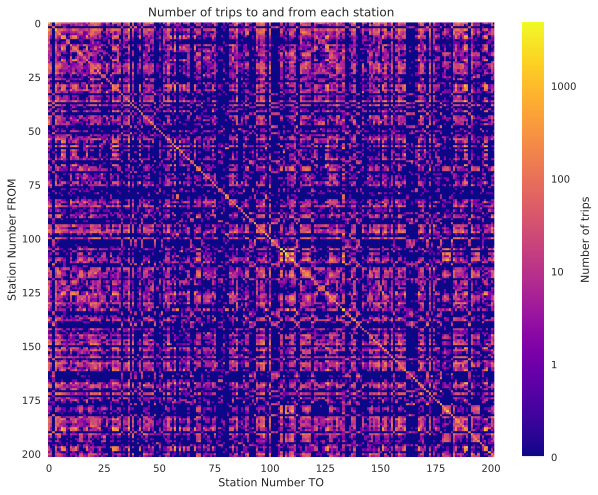

In [60]:
# Plot trips to and from each station
sns.set_style("dark")
plt.figure(figsize=(10, 8))
plt.imshow(np.log10(flow.values+0.1),
           aspect='auto',
           interpolation="nearest")
plt.set_cmap('plasma')
cbar = plt.colorbar(ticks=[-1,0,1,2,3])
cbar.set_label('Number of trips')
cbar.ax.set_yticklabels(['0','1','10','100','1000'])
plt.ylabel('Station Number FROM')
plt.xlabel('Station Number TO')
plt.title('Number of trips to and from each station')
plt.show()

There's a clear diagonal line across the plot - this indicates that many trips end at the same station at which they started, because the diagonal corresponds to where the row number is the same as the column number (the start station is the same as the end station).

Is this the norm?  Do most trips actually return to the station they started from?

In [ ]:
# Plot num trips returning to same station
sns.set()
plt.figure()
plt.bar([0, 1], 
        [np.trace(flow.values), 
         flow.values.sum()-np.trace(flow.values)],
        tick_label=['Same as start', 'Other'])
plt.xlabel('End station')
plt.ylabel('Number of trips')
plt.title('Number of trips which end\n'+
          'at same station they started from')
plt.show()

Nope - most trips don't actually return to the station the started from.  But how popular is the most popular destination from each station relative to coming back to that station?

In [ ]:
# Compute num trips to self + most popular other
V = flow.copy().values
num_same = np.trace(V)
np.fill_diagonal(V, np.nan)
second_best = np.nanmax(V, axis=0).sum()

# Plot num trips returning to same station
plt.figure()
plt.bar([0, 1], [num_same, second_best],
        tick_label=['Same as start', 'Most popular other'])
plt.xlabel('End station')
plt.ylabel('Number of trips')
plt.title('Trips which end at same station\n'+
          'vs most popular other station')
plt.show()

Coming back to the same station is the most popular trip, although there are nearly as many trips as to a second-most-popular station.

Are there clusters of stations that customers ride between?  For example, do people mostly ride from the downtown stations to other downtown stations?  Or, say, between Uptown and Bde Maka Ska?  The matrix from before didn't group stations in any way, or arrange them in any particular order, so we weren't able to get this information from that plot.  However, we can hierarchically cluster the flow patterns between stations, in order to see which groups of stations have many rides between themselves, but not as many to other stations outside the group.

We'll compute the "distance" or "disconnectedness" between a pair of stations by taking the inverse of the number of trips between that pair of stations.  Then we can plot a [dendrogram](https://en.wikipedia.org/wiki/Dendrogram) which shows how disconnected different groups of stations are.

In [ ]:
# Normalized flow (proportion trips to OR from)
names = flow.index.tolist() #station names
counts = flow.values #trip counts
sflow = counts+np.transpose(counts) #symmetric
dist = 1.0/(sflow+1) #"distance"
np.fill_diagonal(dist, 0.0) #0 distance to same station

# Dendrogram
sns.set_style("dark")
plt.figure(figsize=(5,20))
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
sdist = squareform(dist)
Z = hierarchy.linkage(sdist, 'ward')
dg = hierarchy.dendrogram(Z, labels=names,
                          orientation='right')
plt.xlabel('Disconnectedness')
plt.ylabel('Station')
plt.title('Hierarchical Clustering of Stations'+
           '\nby traffic between them')
plt.show()

In [ ]:
# Get the ordering of the dendrogram
inds = [names.index(sn) for sn in dg['ivl']]

# Get trip counts ordered by dendrogram
counts = flow.copy().values[inds,:]
counts = counts[:,inds]
counts = np.log10(counts)
counts[counts<0] = -1

# Plot the log flow matrix
plt.figure(figsize=(10, 8))
plt.imshow(counts,
           aspect='auto',
           interpolation="nearest")
plt.set_cmap('plasma')
cbar = plt.colorbar(ticks=[-1,0,1,2,3])
cbar.set_label('Number of trips')
cbar.ax.set_yticklabels(['0','1','10','100','1000'])
plt.ylabel('Station FROM')
plt.xlabel('Station TO')
plt.yticks([], [])
snums = range(len(dg['ivl']))
plt.xticks(snums[0::5], dg['ivl'][0::5],
           rotation='vertical')
plt.yticks([], [])
plt.title('Number of trips to and from each station'+
          '\nsorted according to hierarchical clustering')
plt.show()

The flow patterns between stations are somewhat clustered.  Stations in St. Paul see more traffic between themselves than to stations in Minneapolis (the cluster on the upper left in the matrix plot and the green cluster at the bottom in the dendrogram).  Stations on the University of Minnesota campus see lots of traffic between themselves (the cluster on the middle in the matrix plot), and stations in downtown Minneapolis see mostly traffic between themselves (large cluster in the lower-right).  However, these clusters aren't completely distinct, and there is obviously a lot of traffic even between stations not in the same "cluster", especially across Minneapolis.

We can also visualize the flow of rides between stations on a map!  Let's plot lines connecting each station, where the line width and color corresponds to how many rides there were from a station to all other stations.  Hover over a station in the map below to see where rides from that station went.

In [92]:
# Get number of trips from each station to each other station
# (row i is num trips from station i)
C = flow.copy().values + 1

# Re-order data in C to match data in stations df
flow_idx = flow.index.tolist()
flow_col = flow['Trips'].columns.tolist()
inds_idx = [flow_idx.index(sn) for sn in stations.Name.tolist()]
inds_col = [flow_col.index(sn) for sn in stations.Name.tolist()]
C = C[inds_idx,:]
C = C[:,inds_col]

# Convert lat,lon to UTM coordinates
X = lon_to_mercX(stations.Longitude)
Y = lat_to_mercY(stations.Latitude)

# Data for bokeh
source = ColumnDataSource(data=dict(
    name = stations.Name.tolist(),
    X = X,
    Y = Y,
    x0 = X[0]*np.ones_like(X),
    y0 = Y[0]*np.ones_like(Y),
    V = C[0,:],
    W = C[0,:]*0.01,
))

# Log color map for line color
mapper = LogColorMapper(palette=Viridis256, 
                        low=0, high=5000)
color = {'field': 'V', 'transform': mapper}

# Plot the points and segments
p = figure(tools="pan,wheel_zoom,reset,save", 
           active_scroll="wheel_zoom")
p.add_tile(CARTODBPOSITRON_RETINA) #background map
p.axis.visible = False
sr = p.segment(x0='x0', y0='y0', x1='X', y1='Y',
               source=source, line_color=color,
               line_width='W', line_cap='round')
cr = p.circle(x='X', y='Y', source=source,
              size=20, color='gray', alpha=0.4, 
              hover_color='gray', hover_alpha=1.0)

# Set lines on hover
min_trips = 10 #don't plot if <10 trips
code = """
var x0 = source.data['x0']
var y0 = source.data['y0']
var X = source.data['X']
var Y = source.data['Y']
var V = source.data['V']
var W = source.data['W']
var indices = cb_data.index['1d'].indices;
if (indices.length > 0) {
    ind = indices[0]
    for (i=0; i<x0.length; i++) {
        x0[i] = X[ind]
        y0[i] = Y[ind]
        V[i] = C[ind][i]
        if (C[ind][i]>%d) {
            W[i] = C[ind][i]*0.01
        } else {
            W[i] = 0.001
        }
    }
}
source.change.emit();
""" % min_trips
callback = CustomJS(args=dict(source=source, C=C), 
                    code=code)
tooltips = [("Station", "@name")]
p.add_tools(HoverTool(tooltips=tooltips, 
                      callback=callback, 
                      renderers=[cr]))

# Color bar
color_bar = ColorBar(color_mapper=mapper, 
                     location=(0, 0))
p.add_layout(color_bar, 'right')

# Show plot
p.title.text = 'Flow between stations'
p.plot_width = 800 
p.plot_height = 500
show(p)

<a id='ride-durations'></a>
## Ride durations

How long did rentals of Nice Ride's bikes usually last? There were an oddly large number of trips larger than 24 hours (but a very small proportion of the total number of trips).

In [ ]:
# Show number of trips longer than 24hrs
Ntd = np.count_nonzero(trips['Total duration (Seconds)']>(24*60*60))
print("Number of trips longer than 24 hours: %d (%0.2g %%)"
      % (Ntd, Ntd/float(len(trips))))

But most trips were under an hour:

In [ ]:
# Show number of trips shorter than 1hr
Ntd = np.count_nonzero(trips['Total duration (Seconds)']<(24*60))
print("Number of trips shorter than 1 hour: %d (%0.2g %%)"
      % (Ntd, Ntd/float(len(trips))))

Let's look at the distribution of trip durations, but only for those under 24 hours.

In [ ]:
# Plot histogram of ride durations
plt.figure()
sns.distplot(trips.loc[trips['Total duration (Seconds)']<(4*60*60),
                       'Total duration (Seconds)']/3600)
plt.xlabel('Ride duration (hrs)')
plt.ylabel('Number of Trips')
plt.title('Ride durations')
plt.show()

<a id='ride-season'></a>
## Ride Season

When are customers renting bikes across the course of the 2017 season?  The first rental is in the beginning of April, and the last rental in the beginning of November:

In [ ]:
# Show first and last rentals of the season
print('First rental: ', min(trips['Start date']))
print('Last rental: ', max(trips['Start date']))

We can also look at the number of rides by month:

In [ ]:
# Plot number of rides per month
plt.figure()
sns.countplot(trips['Start date'].dt.month)
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.title('Number of rentals by month in 2017')
plt.show()

The most popular month to rent is July, though there are still a lot of rentals in non-prime months - there are still almost half as many rentals in April and October as in July.

We can also look at the number of rentals by the week in the year, and the day of the year:

In [ ]:
# Plot number of rides per week
plt.figure(figsize=(6, 7))
sns.countplot(y=trips['Start date'].dt.week)
plt.ylabel('Week')
plt.xlabel('Number of Trips')
plt.title('Number of rentals by week in 2017')
plt.show()

In [ ]:
# Plot number of rides per day of the year
trips.groupby(trips['Start date'].dt.dayofyear)['Start date'].count().plot()
plt.xlabel('Day of the year')
plt.ylabel('Number of rentals')
plt.title('Number of rentals by day of the year in 2017')
holidays = [("Mother's day", 134),
            ("Memorial day", 149),
            ("4th of July", 185),
            ("Labor day", 247), 
            ("Oct 27", 300)]
for name, day in holidays:
    plt.plot([day,day], [0,6000], 
             'k--', linewidth=0.2)
    plt.text(day, 6000, name, fontsize=8, 
             rotation=90, ha='right', va='top')
plt.show()

Like the plot by months, we can see that the number of rentals ramps up and then down again over the course of the summer, with peak rentals on the week leading up to the 4th of July.  There's also a clear increase in the number of rentals on holiday weekends.

There also seems to be an oscillatory pattern to the volume of rentals, which could perhaps be due to the day of the week.  Let's take a look at the number of rentals by the day of the week:

In [ ]:
# Plot number of rides per day of the week
plt.figure()
sns.countplot(trips['Start date'].dt.weekday)
plt.xlabel('Day')
plt.ylabel('Number of Trips')
plt.title('Number of rentals by day of the week in 2017')
plt.xticks(np.arange(7),
           ['M', 'T', 'W', 'Th', 'F', 'Sa', 'Su'])
plt.show()

Indeed it looks like there are more rentals on the weekends (and Fridays) than during weekdays, although not vastly more.

Looking at the rides across the year made me wonder if people would continue riding bikes later into the season as long as the weather was nice.  Nice Ride ended their season in early November, but there were still around 1000 rider per day through most of October.  Notice the sharp drop in rentals on Oct 27th, when there was a [sudden cold snap](https://www.weather.gov/media/mpx/Climate/MSP/oct2017.pdf) and daily high temperatures dropped from the low 60s (brisk but still pleasant biking weather) to the low 30s.  

What if that cold snap hadn't happened?  It's possible that people may have continued renting bikes, and Nice Ride could have continued earning revenue.  Could Nice Ride optimize when they end their season for the year in order to earn more revenue?  Let's first see how weather affected the number of rentals, and then we'll get back to that question.

<a id='weather'></a>
## Weather

How does riding activity depend on the weather?
 -Temperature, cloudy, and rain
 
 look at how it effects both 
 - number of rides/day, and
 - ride durations
 
 should download historical weather data for Minneapolis, and ADD IT TO THE NICERIDE DATASET
 here are some possibilities:
 daily: https://www.climate.gov/maps-data/dataset/past-weather-zip-code-data-table
 

<a id='dependence-on-season'></a> 
 ## Traffic dependence on season
 
 "now that we have the weather data, we can get back to our question of why people ride less in the beginning/end of a season"
Is there a seasonal dependence in riding activity independent of the weather?
- Look at residuals over season after regressing out weather
- The idea is: do people just not wanna ride bikes as much in the fall even if it's nice out?
- And talk about how the idea is to in a later post see if it would be profitable to keep their season going longer

BTW i'd predict that riding activity, after controlling for weather, actually ramps up over the course of a season.
which would mean it wouldn't be profitable to open *earlier* but it **would** be profitable to extend the riding season further into the fall.

<a id='memberships'></a>
## Memberships

Basic hist of memberships

Is there a difference in the bike patterns between rides by people with a membership vs people without one?

Difference in durations? times of day? Day of week? Season?

Trip patterns?
- Compute the transition (or trip) probability matrix for members and separately for non members
- Does it significantly differ?
- Or could bootstrap to get distributions for each trip, compute roc to get prob members take that trip more often (don't bother with significance testing unless there's one or two you are really interested in...)
- Then find the M best stations to put ads at (the M stations which maximize the probability that a person with a riding pattern similar to people with memberships will see it)
- Mention that this assumes that people who have bike patterns that are similar to those people with memberships are more likely to actually get memberships. And say that in fact what you would really want to do is do a/b testing or Bandit algorithm.


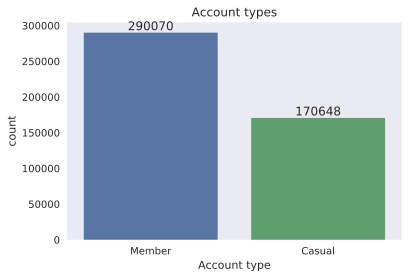

In [93]:
# Plot counts of account types
ax = sns.countplot(x='Account type', data=trips)
plt.title('Account types')
for p in ax.patches:
    x = p.get_bbox().get_points()[:,0]
    y = p.get_bbox().get_points()[1,1]
    ax.annotate('%d' % (y), (x.mean(), y), 
                ha='center', va='bottom')
plt.show()

Rides by members were much more common during weekdays, while non-member activity peaked on the weekends:

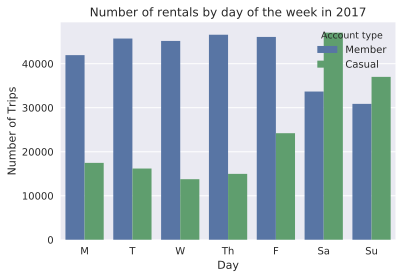

In [94]:
# Plot number of rides per day of the week
sns.set()
plt.figure()
sns.countplot(x=trips['Start date'].dt.weekday,
              hue=trips['Account type'])
plt.xlabel('Day')
plt.ylabel('Number of Trips')
plt.title('Number of rentals by day of the week in 2017')
plt.xticks(np.arange(7),
           ['M', 'T', 'W', 'Th', 'F', 'Sa', 'Su'])
plt.show()

For members, there was a clear increase in traffic around the morning rush hour, lunch, and evening rush hour, while non-members showed a less specific activity pattern which started in the late morning and ended in the evening.

In [ ]:
# Plot number of rides by hour
plt.figure()
sns.countplot(x=trips['Start date'].dt.hour,
              hue=trips['Account type'])
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.title('Number of rentals by hour in 2017')
plt.show()

There wasn't a huge difference between members and non-members over the course of the season, besides that more members are still riding towards the end of the season in October:

In [ ]:
# Plot number of rides per week
plt.figure(figsize=(6, 7))
sns.countplot(y=trips['Start date'].dt.week,
              hue=trips['Account type'])
plt.ylabel('Week')
plt.xlabel('Number of Trips')
plt.title('Number of rentals by week in 2017')
plt.show()

Members had shorter trips on average than non-members.

In [ ]:
# Plot histogram of ride durations
plt.figure()
sns.violinplot(x='Total duration (Seconds)',
               y='Account type',
               data=trips.loc[trips['Total duration (Seconds)']<6000,:])
plt.title('Ride durations\nMembers vs non-members')
plt.show()